# Comparison of velocities among RegVelo, veloVI and scVelo on cell cycle dataset

## Library imports

In [1]:
import os
import sys
from tqdm import tqdm

import tensorflow
import numpy as np
import pandas as pd
import torch
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import accuracy_score
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.colors import to_hex

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics

#from _calculation import get_gams
sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

2024-08-10 17:37:19.756404: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 17:37:24.270662: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 17:37:24.270918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 17:37:24.275918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 17:37:25.656471: I tensorflow/core/platform/cpu_feature_g

In [2]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from distributed import Client, LocalCluster

In [3]:
from regvelovi import REGVELOVI
from typing import Literal
from velovi import preprocess_data, VELOVI
import anndata

In [4]:
import scipy
import sklearn
import unitvelo as utv
import re

import torch.nn.functional as F
from scipy.spatial.distance import cdist

(Running UniTVelo 0.2.5.2)
2024-08-10 15:41:57


## General settings

In [5]:
scvi.settings.dl_pin_memory_gpu_training = False

In [6]:
plt.rcParams['svg.fonttype'] = 'none'

In [7]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [8]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'cell_cycle', exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'cell_cycle', exist_ok=True)

## Function definitions

In [9]:
def fit_scvelo(adata):
    scv.tl.recover_dynamics(
        adata, fit_scaling=False, var_names=adata.var_names, n_jobs=8
    )
    adata.var["fit_scaling"] = 1.0
    scv.tl.velocity(adata, mode="dynamical", min_likelihood=-np.inf, min_r2=None)

In [10]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [11]:
def fit_velovi_data(data,vae):
    bdata = data.copy()
    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return bdata

In [12]:
def compute_confidence(adata, vkey="velocity"):
    velo = adata.layers[vkey]
    scv.tl.velocity_graph(adata, vkey=vkey, n_jobs=1)
    scv.tl.velocity_confidence(adata, vkey=vkey)

    g_df = pd.DataFrame()
    g_df["Velocity confidence"] = adata.obs[f"{vkey}_confidence"].to_numpy().ravel()

    return g_df

In [13]:
def add_significance2(ax, bottom: int, top: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    left, right = ax.get_xlim()
    x_axis_range = right - left

    bracket_level = (x_axis_range * 0.07 * level) + right * bracket_level
    bracket_height = bracket_level - (x_axis_range * bracket_height)
    
    ax.plot(
        [bracket_height, bracket_level, bracket_level, bracket_height],
        [bottom, bottom, top, top], **kwargs
    )

    ax.text(
        bracket_level + (x_axis_range * text_height),
        (bottom + top) * 0.5,
        significance,
        va='center',
        ha='left',
        c='k',
        rotation=90
    )

In [14]:
def get_classification_scores(velo_sign_true, velo_sign_pred, score_fun, **kwargs):
    n_vars = velo_sign_true.shape[1]
    regvi_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["RegVI"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]
    
    em_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["EM"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]

    vi_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["VI"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]
    
    control_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["full_negative_compare"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]
    
    return regvi_score, em_score, vi_score, control_score

In [15]:
def get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [16]:
def plot_classification_score(em_score, vi_score, baseline_performance, score_name, **kwargs):
    n_vars = len(em_score)
    df = pd.DataFrame(
        {
            score_name: vi_score + em_score + baseline_performance,
            "Model": ["VI"] * n_vars + ["EM"] * n_vars + ["Random"] * n_vars
        }
    )

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))

        sns.boxplot(data=df, x="Model", y=score_name, palette="colorblind", ax=ax)

In [17]:
def add_regvelo_outputs_to_adata(adata_raw, vae, filter = False):
    latent_time = vae.get_latent_time(n_samples=30, time_statistic = "mean",batch_size = adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, velo_statistic="mean",batch_size = adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    ## calculate likelihood
    
    return adata

def GRN_Jacobian(reg_vae,Ms):
    net = reg_vae.module.v_encoder.fc1.weight.detach()
    bias = reg_vae.module.v_encoder.fc1.bias.detach() 
    max_rate = reg_vae.module.v_encoder.alpha_unconstr_max.detach()
    ## calculate the jacobian matrix respect to each cell
    Jaco_m = []
    for i in range(Ms.shape[0]):
        s = Ms[i,:]
        Jaco_m.append(reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach())
    Jaco_m = torch.stack(Jaco_m,2)
    return Jaco_m

## Data loading

In [18]:
adata = sc.read("RegVelo_datasets/cell cycle/adata.h5ad")
adata.X = adata.layers["spliced"].copy()

del adata.layers["ambiguous"]
del adata.layers["matrix"]
del adata.layers["spanning"]

adata.obs.drop(
    ["Well_Plate", "plate", "MeanGreen530", "MeanRed585", "initial_size_unspliced", "initial_size_spliced", "initial_size"],
    axis=1,
    inplace=True
)

adata.var_names = adata.var["name"].values
adata.var.drop(adata.var.columns, axis=1, inplace=True)

adata.obs["pseudo_clusters"] = pd.cut(adata.obs["fucci_time"], bins=5, labels=False).astype(str).astype("category")

adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["fucci_time"], q=5, labels=False)
adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)

adata.obs["cell_cycle_rad"] = adata.obs["fucci_time"] / adata.obs["fucci_time"].max() * 2 * np.pi

adata

AnnData object with n_obs × n_vars = 1146 × 19997
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad'
    layers: 'spliced', 'unspliced'

## Data preprocessing

In [19]:
scv.pp.filter_and_normalize(adata, min_counts=10,n_top_genes = 2000)

Filtered out 4748 genes that are detected 10 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [20]:
sc.tl.pca(adata, svd_solver='arpack')
#sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [21]:
sc.tl.umap(adata)

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


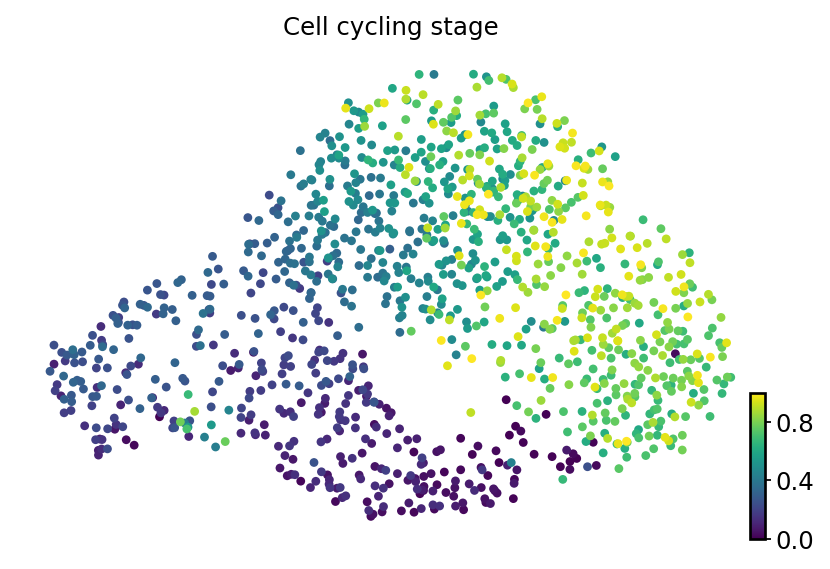

In [22]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis='umap', color='fucci_time', cmap='viridis',title = "Cell cycling stage",ax = ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'cell_cycle'/ 'cell_cycle_umap.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

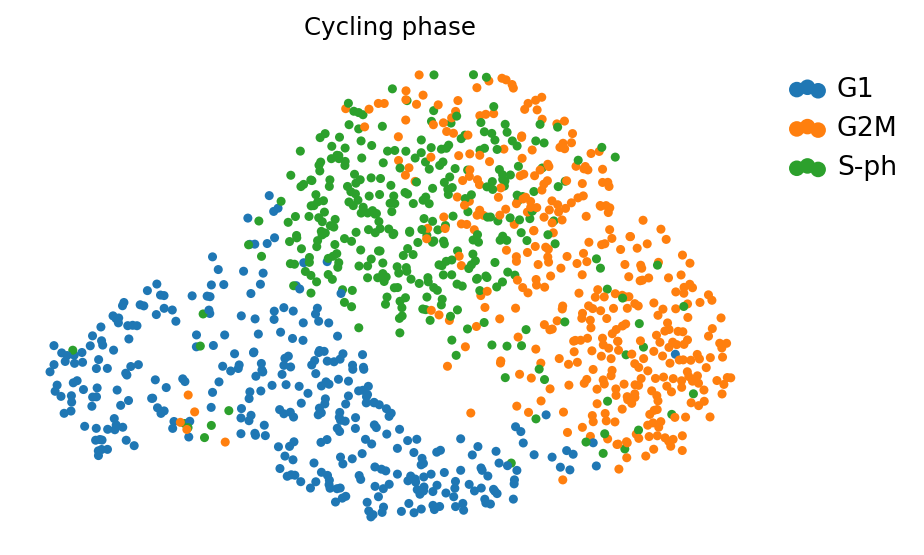

In [23]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata[adata.obs["phase"] != "N/A"], basis='umap', color='phase',title = "Cycling phase",ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'cell_cycle'/ 'phase_umap.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [24]:
adata = preprocess_data(adata)

bdata = adata.copy()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [25]:
if SAVE_DATASETS:
    adata.write(DATA_DIR / "cell_cycle" / "cell_cycle_processed.h5ad")

## Model fitting

### EM model

In [26]:
fit_scvelo(adata)

recovering dynamics (using 8/112 cores)


  0%|          | 0/395 [00:00<?, ?gene/s]

    finished (0:00:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


### veloVI

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 431/500:  86%|████████▌ | 431/500 [00:43<00:06,  9.86it/s, loss=-576, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -580.638. Signaling Trainer to stop.


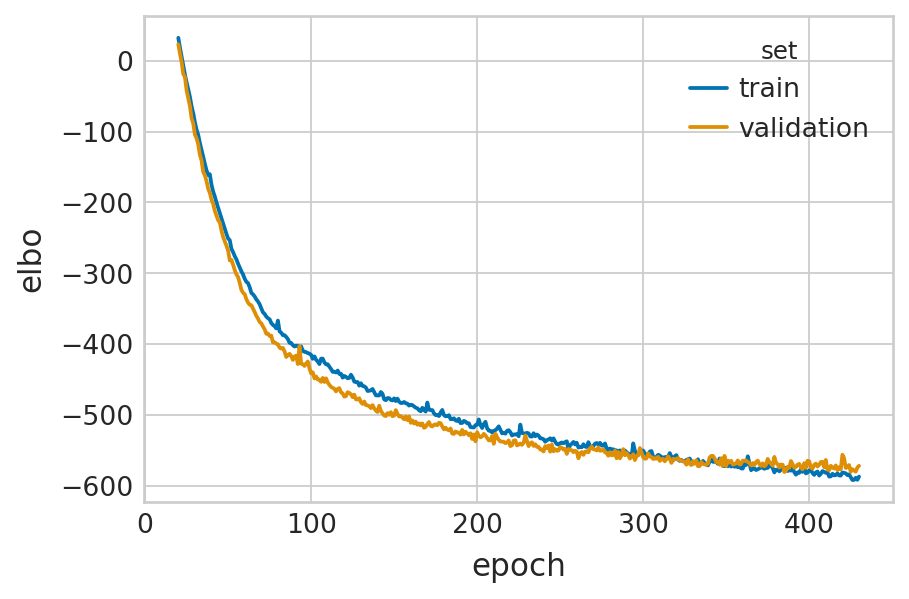

In [27]:
velovi_vae = fit_velovi(bdata)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:47<00:00, 10.46it/s, loss=-577, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:47<00:00, 10.55it/s, loss=-577, v_num=1]


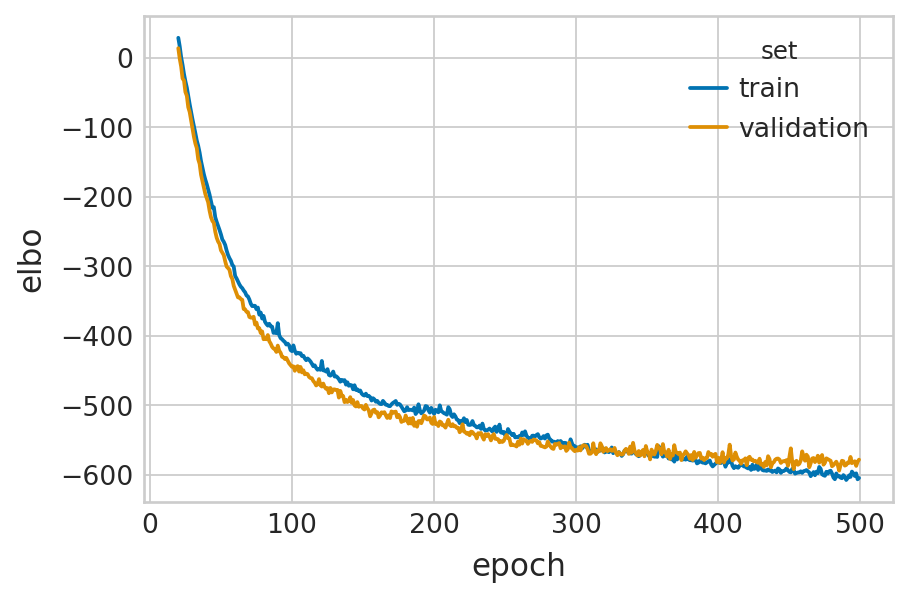

In [28]:
bdata2 = bdata.copy()
velovi_vae2 = fit_velovi(bdata2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:45<00:00, 11.42it/s, loss=-547, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:45<00:00, 11.03it/s, loss=-547, v_num=1]


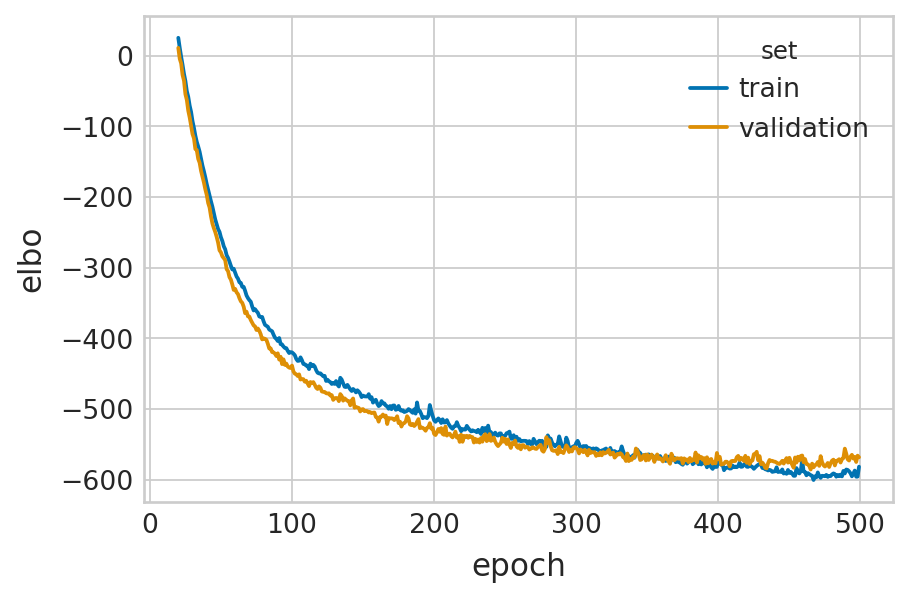

In [29]:
bdata3 = bdata.copy()
velovi_vae3 = fit_velovi(bdata3)

### RegVelo

In [30]:
reg_bdata = bdata.copy()

## inject a skeleton matrix
## the graph structure is full so use L1 to learn the gene regulatory network
reg_bdata.uns["regulators"] = bdata.var.index.values
reg_bdata.uns["targets"] = bdata.var.index.values
reg_bdata.uns["skeleton"] = np.ones((len(bdata.var.index),len(bdata.var.index)))
reg_bdata.uns["network"] = np.ones((len(bdata.var.index),len(bdata.var.index)))
reg_bdata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'pca', 'neighbors', 'umap', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid', 'regulators', 'targets', 'skeleton', 'network'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocities_velovi', 'latent_time_velovi', 'fit_t'
    obsp: 'distances', 'connectivities'

In [31]:
W = reg_bdata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

W

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [32]:
REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(reg_bdata,W=W.T)

In [33]:
reg_vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1100/1500:  73%|███████▎  | 1100/1500 [06:36<02:24,  2.77it/s, loss=-817, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -943.581. Signaling Trainer to stop.


In [34]:
reg_vae2 = REGVELOVI(reg_bdata,W=W.T)
reg_vae2.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1251/1500:  83%|████████▎ | 1251/1500 [07:32<01:30,  2.76it/s, loss=-864, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -964.674. Signaling Trainer to stop.


In [35]:
reg_vae3 = REGVELOVI(reg_bdata,W=W.T)
reg_vae3.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1145/1500:  76%|███████▋  | 1145/1500 [06:48<02:06,  2.81it/s, loss=-836, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -962.444. Signaling Trainer to stop.


In [37]:
## save model
if SAVE_DATASETS:
    reg_vae.save(DATA_DIR / "cell_cycle" / "model_1")
    reg_vae2.save(DATA_DIR / "cell_cycle" / "model_2")
    reg_vae3.save(DATA_DIR / "cell_cycle" / "model_3")

In [35]:
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)
adata_target2 = add_regvelo_outputs_to_adata(reg_bdata, reg_vae2)
adata_target3 = add_regvelo_outputs_to_adata(reg_bdata, reg_vae3)

In [36]:
## quantify latent time correlation
regvi_t_cor = []
adata_target.obs["latent_time"] = np.mean(adata_target.layers["fit_t"],axis = 1)
regvi_t_cor.append(scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["fucci_time"])[0])
adata_target2.obs["latent_time"] = np.mean(adata_target2.layers["fit_t"],axis = 1)
regvi_t_cor.append(scipy.stats.spearmanr(adata_target2.obs["latent_time"], adata_target2.obs["fucci_time"])[0])
adata_target3.obs["latent_time"] = np.mean(adata_target3.layers["fit_t"],axis = 1)
regvi_t_cor.append(scipy.stats.spearmanr(adata_target3.obs["latent_time"], adata_target3.obs["fucci_time"])[0])

vi_t_cor = []
bdata.obs["latent_time"] = np.mean(bdata.layers["fit_t"],axis = 1)
vi_t_cor.append(scipy.stats.spearmanr(bdata.obs["latent_time"], bdata.obs["fucci_time"])[0])
bdata2.obs["latent_time"] = np.mean(bdata2.layers["fit_t"],axis = 1)
vi_t_cor.append(scipy.stats.spearmanr(bdata2.obs["latent_time"], bdata2.obs["fucci_time"])[0])
bdata3.obs["latent_time"] = np.mean(bdata3.layers["fit_t"],axis = 1)
vi_t_cor.append(scipy.stats.spearmanr(bdata3.obs["latent_time"], bdata3.obs["fucci_time"])[0])

em_t_cor = []
adata.obs["latent_time"] = np.mean(adata.layers["fit_t"],axis = 1)
em_t_cor.append(scipy.stats.spearmanr(adata.obs["latent_time"], adata.obs["fucci_time"])[0])

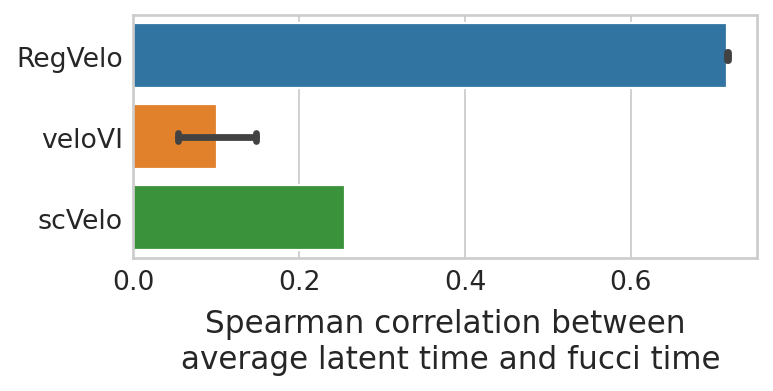

In [37]:
## perform boxplot
data_t = pd.DataFrame({
    'Method': ['RegVelo'] * len(regvi_t_cor) + ['veloVI'] * len(vi_t_cor) + ['scVelo'] * len(em_t_cor),
    'Performance': regvi_t_cor + vi_t_cor + em_t_cor
})

# Draw boxplot using Seaborn
pal = {"RegVelo":"#f3e1eb","veloVI":"#b5bbe3","scVelo":"#0fcfc0"}
# Draw boxplot using Seaborn
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 2))
    #sns.boxplot(y='Method', x='Performance', data=data,order = ["RegVelo","veloVI","scVelo"],palette=pal)
    sns.barplot(y='Method', x='Performance',data=data_t, ci='sd', capsize=0.1,order = ["RegVelo","veloVI","scVelo"],ax = ax)
    plt.xlabel('Spearman correlation between\n average latent time and fucci time',fontsize = 14)
    plt.ylabel('')

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'Latent_time_correlation.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

In [38]:
bdata.layers["velocity"] = bdata.layers["velocities_velovi"].copy()
bdata2.layers["velocity"] = bdata2.layers["velocities_velovi"].copy()
bdata3.layers["velocity"] = bdata3.layers["velocities_velovi"].copy()

In [39]:
## Benchmark cross boundary score
adata_target.obsm["X_pca"] = adata.obsm["X_pca"].copy()
adata_target2.obsm["X_pca"] = adata.obsm["X_pca"].copy()
adata_target3.obsm["X_pca"] = adata.obsm["X_pca"].copy()

bdata.obsm["X_pca"] = adata.obsm["X_pca"].copy()
bdata2.obsm["X_pca"] = adata.obsm["X_pca"].copy()
bdata3.obsm["X_pca"] = adata.obsm["X_pca"].copy()

In [40]:
scv.tl.velocity_graph(adata_target)
scv.tl.velocity_graph(adata_target2)
scv.tl.velocity_graph(adata_target3)

scv.tl.velocity_graph(bdata)
scv.tl.velocity_graph(bdata2)
scv.tl.velocity_graph(bdata3)

computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [41]:
## benchmark velocity directioness across phase boundary
scv.tl.velocity_embedding(adata_target, basis='pca')
scv.tl.velocity_embedding(adata_target2, basis='pca')
scv.tl.velocity_embedding(adata_target3, basis='pca')

scv.tl.velocity_embedding(bdata, basis='pca')
scv.tl.velocity_embedding(bdata2, basis='pca')
scv.tl.velocity_embedding(bdata3, basis='pca')

scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis='pca')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [42]:
### predict the phase
label = "phase"
cluster_edges = [
    ("G1", "S-ph"),
    ("S-ph", "G2M")]
regvi = utv.evaluate(adata_target, cluster_edges, label, 'velocity', x_emb = 'X_pca')
regvi2 = utv.evaluate(adata_target2, cluster_edges, label, 'velocity', x_emb = 'X_pca')
regvi3 = utv.evaluate(adata_target3, cluster_edges, label, 'velocity', x_emb = 'X_pca')
vi = utv.evaluate(bdata, cluster_edges, label, 'velocity', x_emb = 'X_pca')
vi2 = utv.evaluate(bdata2, cluster_edges, label, 'velocity', x_emb = 'X_pca')
vi3 = utv.evaluate(bdata3, cluster_edges, label, 'velocity', x_emb = 'X_pca')
em = utv.evaluate(adata, cluster_edges, label, 'velocity', x_emb = 'X_pca')

# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.25896496966512067, ('S-ph', 'G2M'): 0.21713173046932682}
Total Mean: 0.23804835006722375
# In-cluster Coherence
{'G1': 0.8480024, 'G2M': 0.9535677, 'N/A': 0.90935326, 'S-ph': 0.9443435}
Total Mean: 0.9138166904449463
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.25929598359154304, ('S-ph', 'G2M'): 0.21722448027757812}
Total Mean: 0.23826023193456058
# In-cluster Coherence
{'G1': 0.84805423, 'G2M': 0.9536801, 'N/A': 0.909197, 'S-ph': 0.9443005}
Total Mean: 0.9138079285621643
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2592372074092663, ('S-ph', 'G2M'): 0.2171866306294291}
Total Mean: 0.2382119190193477
# In-cluster Coherence
{'G1': 0.84800094, 'G2M': 0.9537319, 'N/A': 0.9093204, 'S-ph': 0.9442909}
Total Mean: 0.9138360023498535
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.17819458857954662, ('S-ph', 'G2M'): 0.18074753211676056}
Total Mean: 0.17947106034815358
# In

In [43]:
regvi = [np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]
regvi2 = [np.mean(regvi2['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(regvi2['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]
regvi3 = [np.mean(regvi3['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(regvi3['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]

vi = [np.mean(vi['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(vi['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]
vi2 = [np.mean(vi2['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(vi2['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]
vi3 = [np.mean(vi3['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(vi3['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]

em = [np.mean(em['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(em['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]

In [44]:
regvi_velo = [np.mean(regvi),np.mean(regvi2),np.mean(regvi3)]
vi_velo = [np.mean(vi),np.mean(vi2),np.mean(vi3)]
em_velo =[np.mean(em)]

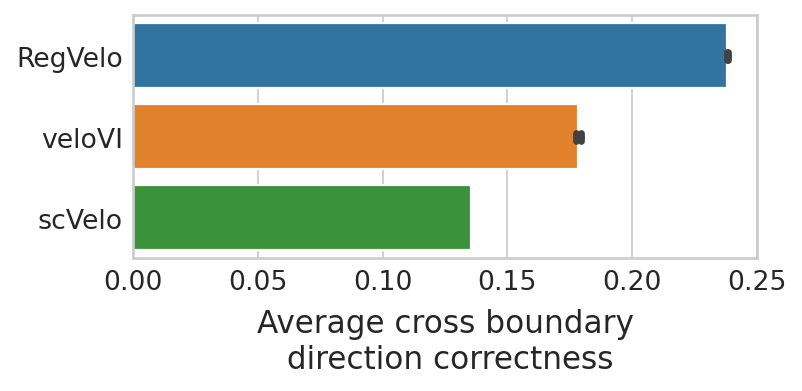

In [45]:
## perform boxplot
data_cdb = pd.DataFrame({
    'Method': ['RegVelo'] * len(regvi_velo) + ['veloVI'] * len(vi_velo) + ['scVelo'] * 1,
    'Performance': regvi_velo + vi_velo + em_velo
})
pal = {"RegVelo":"#f3e1eb","veloVI":"#b5bbe3","scVelo":"#0fcfc0"}
# Draw boxplot using Seaborn
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 2))
    #sns.boxplot(y='Method', x='Performance', data=data,order = ["RegVelo","veloVI","scVelo"],palette=pal)
    sns.barplot(y='Method', x='Performance',data=data_cdb, ci='sd', capsize=0.1,order = ["RegVelo","veloVI","scVelo"],ax = ax)
    plt.xlabel('Average cross boundary\n direction correctness',fontsize = 14)
    plt.ylabel('')
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'CBC_score.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

In [46]:
### predict the phase (bacward)
label = "phase"
cluster_edges = [
    ("S-ph","G1"),
    ("G2M","S-ph")]
regvi = utv.evaluate(adata_target, cluster_edges, label, 'velocity', x_emb = 'X_pca')
regvi2 = utv.evaluate(adata_target2, cluster_edges, label, 'velocity', x_emb = 'X_pca')
regvi3 = utv.evaluate(adata_target3, cluster_edges, label, 'velocity', x_emb = 'X_pca')
vi = utv.evaluate(bdata, cluster_edges, label, 'velocity', x_emb = 'X_pca')
vi2 = utv.evaluate(bdata2, cluster_edges, label, 'velocity', x_emb = 'X_pca')
vi3 = utv.evaluate(bdata3, cluster_edges, label, 'velocity', x_emb = 'X_pca')
em = utv.evaluate(adata, cluster_edges, label, 'velocity', x_emb = 'X_pca')

# Cross-Boundary Direction Correctness (A->B)
{('S-ph', 'G1'): -0.15370667086248727, ('G2M', 'S-ph'): -0.02421810700024591}
Total Mean: -0.08896238893136658
# In-cluster Coherence
{'G1': 0.8480024, 'G2M': 0.9535677, 'N/A': 0.90935326, 'S-ph': 0.9443435}
Total Mean: 0.9138166904449463
# Cross-Boundary Direction Correctness (A->B)
{('S-ph', 'G1'): -0.15374613030718318, ('G2M', 'S-ph'): -0.02406801276350449}
Total Mean: -0.08890707153534383
# In-cluster Coherence
{'G1': 0.84805423, 'G2M': 0.9536801, 'N/A': 0.909197, 'S-ph': 0.9443005}
Total Mean: 0.9138079285621643
# Cross-Boundary Direction Correctness (A->B)
{('S-ph', 'G1'): -0.1537672078185997, ('G2M', 'S-ph'): -0.02403726555837318}
Total Mean: -0.08890223668848644
# In-cluster Coherence
{'G1': 0.84800094, 'G2M': 0.9537319, 'N/A': 0.9093204, 'S-ph': 0.9442909}
Total Mean: 0.9138360023498535
# Cross-Boundary Direction Correctness (A->B)
{('S-ph', 'G1'): -0.11799695875391923, ('G2M', 'S-ph'): -0.05729347869607642}
Total Mean: -0.08764521

In [47]:
regvi = [np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('S-ph', 'G1')]),np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('G2M', 'S-ph')])]
regvi2 = [np.mean(regvi2['Cross-Boundary Direction Correctness (A->B)'][('S-ph', 'G1')]),np.mean(regvi2['Cross-Boundary Direction Correctness (A->B)'][('G2M', 'S-ph')])]
regvi3 = [np.mean(regvi3['Cross-Boundary Direction Correctness (A->B)'][('S-ph', 'G1')]),np.mean(regvi3['Cross-Boundary Direction Correctness (A->B)'][('G2M', 'S-ph')])]

vi = [np.mean(vi['Cross-Boundary Direction Correctness (A->B)'][('S-ph', 'G1')]),np.mean(vi['Cross-Boundary Direction Correctness (A->B)'][('G2M', 'S-ph')])]
vi2 = [np.mean(vi2['Cross-Boundary Direction Correctness (A->B)'][('S-ph', 'G1')]),np.mean(vi2['Cross-Boundary Direction Correctness (A->B)'][('G2M', 'S-ph')])]
vi3 = [np.mean(vi3['Cross-Boundary Direction Correctness (A->B)'][('S-ph', 'G1')]),np.mean(vi3['Cross-Boundary Direction Correctness (A->B)'][('G2M', 'S-ph')])]

em = [np.mean(em['Cross-Boundary Direction Correctness (A->B)'][('S-ph', 'G1')]),np.mean(em['Cross-Boundary Direction Correctness (A->B)'][('G2M', 'S-ph')])]

In [48]:
regvi_velo = [np.mean(regvi),np.mean(regvi2),np.mean(regvi3)]
vi_velo = [np.mean(vi),np.mean(vi2),np.mean(vi3)]
em_velo =[np.mean(em)]

In [49]:
regvi_velo = list((1 - np.array(regvi_velo))/2)
vi_velo = list((1 - np.array(vi_velo))/2)
em_velo = list((1 - np.array(em_velo))/2)

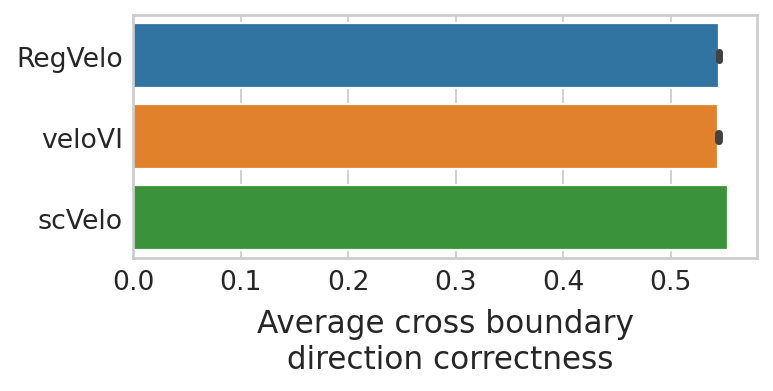

In [50]:
## perform boxplot
data_cdb = pd.DataFrame({
    'Method': ['RegVelo'] * len(regvi_velo) + ['veloVI'] * len(vi_velo) + ['scVelo'] * 1,
    'Performance': regvi_velo + vi_velo + em_velo
})
pal = {"RegVelo":"#f3e1eb","veloVI":"#b5bbe3","scVelo":"#0fcfc0"}
# Draw boxplot using Seaborn
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 2))
    #sns.boxplot(y='Method', x='Performance', data=data,order = ["RegVelo","veloVI","scVelo"],palette=pal)
    sns.barplot(y='Method', x='Performance',data=data_cdb, ci='sd', capsize=0.1,order = ["RegVelo","veloVI","scVelo"],ax = ax)
    plt.xlabel('Average cross boundary\n direction correctness',fontsize = 14)
    plt.ylabel('')
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'CBC_score(backward).svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

### Comparing velocity confidence

In [51]:
dfs = []

g_df = compute_confidence(adata_target, vkey="velocity")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "RegVelo"
dfs.append(g_df)

g_df = compute_confidence(bdata, vkey="velocities_velovi")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "veloVI"
dfs.append(g_df)

g_df = compute_confidence(adata)
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "scVelo"
dfs.append(g_df)


conf_df = pd.concat(dfs, axis=0)

computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocities_velovi_length' (adata.obs)
--> added 'velocities_velovi_confidence' (adata.obs)
--> added 'velocities_velovi_confidence_transition' (adata.obs)
computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


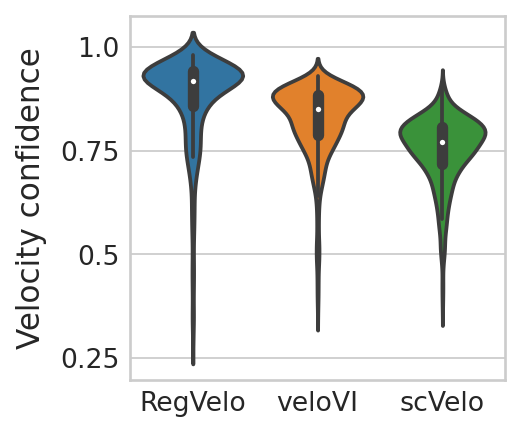

In [52]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3))
    pal = {"RegVelo":"#f3e1eb","veloVI":"#b5bbe3","scVelo":"#0fcfc0"}
    
    sns.violinplot(
        data=conf_df,
        ax=ax,
        #orient="h",
        x="Method",
        y="Velocity confidence",
        order = ["RegVelo","veloVI","scVelo"],
    );
    #plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels([0.25, 0.5, 0.75, 1.0]);
    plt.xlabel("")

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'Consistency.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

## Benchmark GRN inference using ChIP-Atlas as ground truth

In [53]:
### collect TF list
TF_list = pd.read_csv("RegVelo_datasets/cell cycle/DatabaseExtract_v_1.01.csv",index_col = 0)
TF_list = TF_list.iloc[:,1]
TF_list = set(TF_list.tolist()).intersection(reg_bdata.var_names)

In [54]:
Jaco_m = GRN_Jacobian(reg_vae3,reg_bdata.layers["Ms"].mean(0).reshape(1,-1))

In [55]:
GRN = torch.mean(Jaco_m,2)

In [56]:
Jaco_m = Jaco_m.cpu().detach()
GRN = GRN.cpu().detach()

In [57]:
GRN = pd.DataFrame(GRN,index = adata_target.var_names, columns = adata_target.var_names)

In [58]:
## compare wth corrlation
regulator_index = [i in reg_bdata.uns["regulators"] for i in reg_bdata.var.index.values]
target_index = [i in reg_bdata.uns["targets"] for i in reg_bdata.var.index.values]

corr_m = 1 - cdist(reg_bdata.layers["Ms"].T, reg_bdata.layers["Ms"].T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()
corr_m = pd.DataFrame(corr_m,index = reg_bdata.var_names, columns = reg_bdata.var_names)

## load the ChIP-Atlas data from folder and benchmark different method

In [59]:
## load spliceJAC and celloracle
TFvelo = pd.read_csv("RegVelo_datasets/cell cycle/TFvelo_GRN.csv",index_col = 0)
spliceJAC = pd.read_csv("RegVelo_datasets/cell cycle/spliceJAC_m.csv",index_col = 0)
celloracle = pd.read_csv("RegVelo_datasets/cell cycle/celloracle_m.csv",index_col = 0)
grnboost_m = pd.read_csv("RegVelo_datasets/cell cycle/GRN_Boost.csv",index_col = 0)

In [60]:
# load TF
folder_path = 'RegVelo_datasets/cell cycle/TF_list_5k'
# Get a list of all files in the folder
files = os.listdir(folder_path)
TF_names = [re.sub(r'.tsv', '', s) for s in files]
TFs_tfvelo = list(set(TF_names).intersection(TFvelo.columns))

In [61]:
os.chdir("RegVelo_datasets/cell cycle/TF_list_5k/")

a_cor = []
a_grnboost = []
a_co = []
a_regvi = []
a_sp = []
a_tfvelo = []
a_random = []

for i in range(len(TF_names)):
    dat = pd.read_csv(files[i],sep="\t")
    dat.index = dat.loc[:,"Target_genes"]
    gene = set(dat.index).intersection(set(reg_bdata.var_names))
    dat = dat.loc[gene,:]
    label = [1 if i in gene else 0 for i in reg_bdata.var_names]
    label_tfv = [1 if i in gene else 0 for i in TFvelo.index.tolist()]
    
    if np.sum(label) > 100:
        pre_cor = np.abs(corr_m.loc[reg_bdata.var_names,TF_names[i]])
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = label, y_score = pre_cor, pos_label = 1) #positive class is 1; negative class is 0
        auroc = sklearn.metrics.auc(fpr, tpr)
        a_cor.append(auroc)
        
        pre_cor = np.random.permutation(np.abs(corr_m.loc[reg_bdata.var_names,TF_names[i]]))
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = label, y_score = pre_cor, pos_label = 1) #positive class is 1; negative class is 0
        auroc = sklearn.metrics.auc(fpr, tpr)
        a_random.append(auroc)

        ## calculate grnboost
        pre_cor = np.abs(grnboost_m.loc[reg_bdata.var_names,TF_names[i]])
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = label, y_score = pre_cor, pos_label = 1) #positive class is 1; negative class is 0
        auroc = sklearn.metrics.auc(fpr, tpr)
        a_grnboost.append(auroc)

        ## calculate celloracle
        pre_cor = np.abs(celloracle.loc[reg_bdata.var_names,TF_names[i]])
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = label, y_score = pre_cor, pos_label = 1) #positive class is 1; negative class is 0
        auroc = sklearn.metrics.auc(fpr, tpr)
        a_co.append(auroc)

        ## calculate spliceJAC
        pre_cor = np.abs(spliceJAC.loc[reg_bdata.var_names,TF_names[i]])
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = label, y_score = pre_cor, pos_label = 1) #positive class is 1; negative class is 0
        auroc = sklearn.metrics.auc(fpr, tpr)
        a_sp.append(auroc)

        ## calculate regvelo
        pre_cor = np.abs(GRN.loc[reg_bdata.var_names,TF_names[i]])
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = label, y_score = pre_cor, pos_label = 1) #positive class is 1; negative class is 0
        auroc = sklearn.metrics.auc(fpr, tpr)
        a_regvi.append(auroc)

        ## calculate TFvelo
        if TF_names[i] in TFs_tfvelo:
            pre_cor = np.abs(TFvelo.loc[:,TF_names[i]])
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = label_tfv, y_score = pre_cor, pos_label = 1) #positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            a_tfvelo.append(auroc)
    
a_cor = np.array(a_cor)
a_grnboost = np.array(a_grnboost)
a_co = np.array(a_co)
a_regvi = np.array(a_regvi)
a_sp = np.array(a_sp)
a_tfvelo = np.array(a_tfvelo)
a_random = np.array(a_random)

In [62]:
s_cor = []
s_grnboost = []
s_co = []
s_regvi = []
s_sp = []
s_random = []
s_tfvelo = []

for i in range(len(TF_names)):
    dat = pd.read_csv(files[i],sep="\t")
    dat.index = dat.loc[:,"Target_genes"]
    gene = set(dat.index).intersection(set(reg_bdata.var_names))
    gene_tfv = set(dat.index).intersection(set(TFvelo.index.tolist()))
    dat_tfv = dat.loc[gene_tfv,:].copy()
    dat = dat.loc[gene,:].copy()
    
    if len(gene) > 100:
        ## calculate correlation
        pre_cor = corr_m.loc[gene,TF_names[i]]
        s_cor.append(scipy.stats.spearmanr(np.abs(pre_cor),np.array(dat.iloc[:,1]))[0])
        s_random.append(scipy.stats.spearmanr(np.abs(pre_cor),np.random.permutation(np.array(dat.iloc[:,1])))[0])

        ## calculate grnboost
        pre_cor = grnboost_m.loc[gene,TF_names[i]]
        s_grnboost.append(scipy.stats.spearmanr(np.abs(pre_cor),np.array(dat.iloc[:,1]))[0])

        ## calculate celloracle
        pre_cor = celloracle.loc[gene,TF_names[i]]
        s_co.append(scipy.stats.spearmanr(np.abs(pre_cor),np.array(dat.iloc[:,1]))[0])

        ## calculate spliceJAC
        pre_cor = spliceJAC.loc[gene,TF_names[i]]
        s_sp.append(scipy.stats.spearmanr(np.abs(pre_cor),np.array(dat.iloc[:,1]))[0])

        ## calculate regvelo
        pre_cor = GRN.loc[gene,TF_names[i]]
        s_regvi.append(scipy.stats.spearmanr(np.abs(pre_cor),np.array(dat.iloc[:,1]))[0])

        if TF_names[i] in TFs_tfvelo:
            pre_cor = TFvelo.loc[gene_tfv,TF_names[i]]
            s_tfvelo.append(scipy.stats.spearmanr(np.abs(pre_cor),np.array(dat_tfv.iloc[:,1]))[0])
    
s_cor = np.array(s_cor)
s_random = np.array(s_random)
s_grnboost = np.array(s_grnboost)
s_co = np.array(s_co)
s_regvi = np.array(s_regvi)
s_tfvelo = np.array(s_tfvelo)
s_sp = np.array(s_sp)

In [63]:
## draw the boxplot
performance = list(s_regvi) + list(s_tfvelo) + list(s_co) + list(s_grnboost) + list(s_cor) + list(s_sp) + list(s_random)
method = ["RegVelo"] * len(s_regvi) + ["TFvelo"] * len(s_tfvelo) + ["CellOracle"] * len(s_co) + ["GRNBoost2"] * len(s_grnboost) + ["Correlation"] * len(s_cor) + ["spliceJAC"] * len(s_sp) + ["random"] * len(s_random)

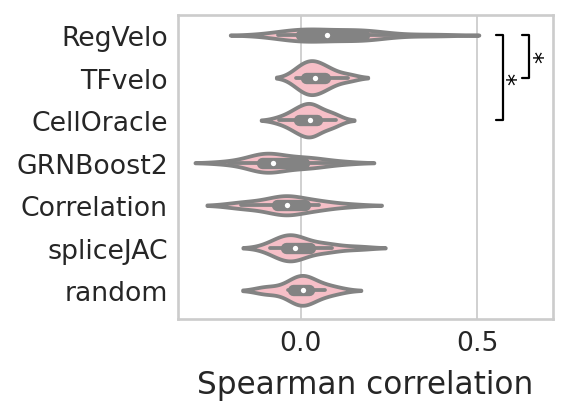

In [64]:
result = pd.DataFrame({"Method": method, "Performance": performance})

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 2.5))

    sns.violinplot(data=result, y="Method", x="Performance", color = "lightpink", ax=ax)

    ttest_res = ttest_ind(result.iloc[:,1][result.iloc[:,0] == "RegVelo"].values, result.iloc[:,1][result.iloc[:,0] == "CellOracle"].values, alternative="greater",)
    significance = get_significance(ttest_res.pvalue)
    add_significance2(
        ax=ax, bottom=0, top=2, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = ttest_ind(result.iloc[:,1][result.iloc[:,0] == "RegVelo"].values, result.iloc[:,1][result.iloc[:,0] == "TFvelo"].values, alternative="greater",)
    significance = get_significance(ttest_res.pvalue)
    add_significance2(
        ax=ax, bottom=0, top=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    x_min, x_max = ax.get_xlim()
    ax.set(ylabel='', xlabel='Spearman correlation')
    ax.set_xlim([x_min, x_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'GRN_spearman.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [65]:
## draw the boxplot
performance = list(a_regvi) + list(a_tfvelo) + list(a_co) + list(a_grnboost) + list(a_cor) + list(a_sp) + list(a_random)
method = ["RegVelo"] * len(a_regvi) + ["TFvelo"] * len(a_tfvelo) + ["CellOracle"] * len(a_co) + ["GRNBoost2"] * len(a_grnboost) + ["Correlation"] * len(a_cor) + ["spliceJAC"] * len(a_sp) + ["random"] * len(a_random)

In [66]:
result = pd.DataFrame({"Method": method, "Performance": performance})

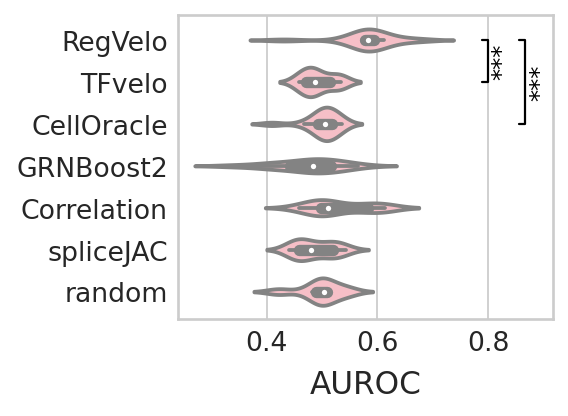

In [67]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 2.5))

    sns.violinplot(data=result, y="Method", x="Performance", color = "lightpink", ax=ax)

    ttest_res = ttest_ind(result.iloc[:,1][result.iloc[:,0] == "RegVelo"].values, result.iloc[:,1][result.iloc[:,0] == "TFvelo"].values, alternative="greater",)
    significance = get_significance(ttest_res.pvalue)
    add_significance2(
        ax=ax, bottom=0, top=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = ttest_ind(result.iloc[:,1][result.iloc[:,0] == "RegVelo"].values, result.iloc[:,1][result.iloc[:,0] == "CellOracle"].values, alternative="greater",)
    significance = get_significance(ttest_res.pvalue)
    add_significance2(
        ax=ax, bottom=0, top=2, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    x_min, x_max = ax.get_xlim()
    ax.set(ylabel='', xlabel='AUROC')
    ax.set_xlim([x_min, x_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'GRN_AUROC.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=30)